original code: https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python

In [36]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
#five base models for Stacking
from sklearn.ensemble import (RandomForestClassifier, 
                             AdaBoostClassifier, 
                             GradientBoostingClassifier, 
                             ExtraTreesClassifier)
from sklearn.svm import SVC

In [40]:
from sklearn.cross_validation import KFold

## Feature exploration,Feature egnineering, and Feature cleaning

In [41]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [42]:
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Feature engineering

In [43]:
full_data = [train, test]

#new feature: name length
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

#new feature: has cabin
train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x:0 if type(x)==float else 1)

#new feature: FamilySize = SibSp + Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

#new feature: IsAlone
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1

#remove null data from Embarked
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

#replace null data from Fare to the median value 
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
#convert numerical feature to categorial feature
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

#replace null data from Age to random value
#the random values are pick from the empirical rule
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
#convert numerical feature to categorial feature
train['CategoricalAge'] = pd.cut(train['Age'], 5)

#extract titles from passenger names if exist
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''
#new feautre: Title
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
#replace rare titles
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

#map categorial features to number
for dataset in full_data:
    #mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    #mapping Title
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    #mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    #mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91,                                  'Fare'] = 0
    dataset.loc[(dataset['Fare'] >  7.91)   & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] >  14.454) & (dataset['Fare'] <= 31),     'Fare'] = 2
    dataset.loc[ dataset['Fare'] >  31,                                    'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    #mapping Age
    dataset.loc[ dataset['Age'] <= 16,                           'Age'] = 0
    dataset.loc[(dataset['Age'] >  16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] >  32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] >  48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] >  64,                           'Age'] = 4

In [44]:
#drop features
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test  = test.drop(drop_elements, axis=1)

## Visualizations

In [45]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


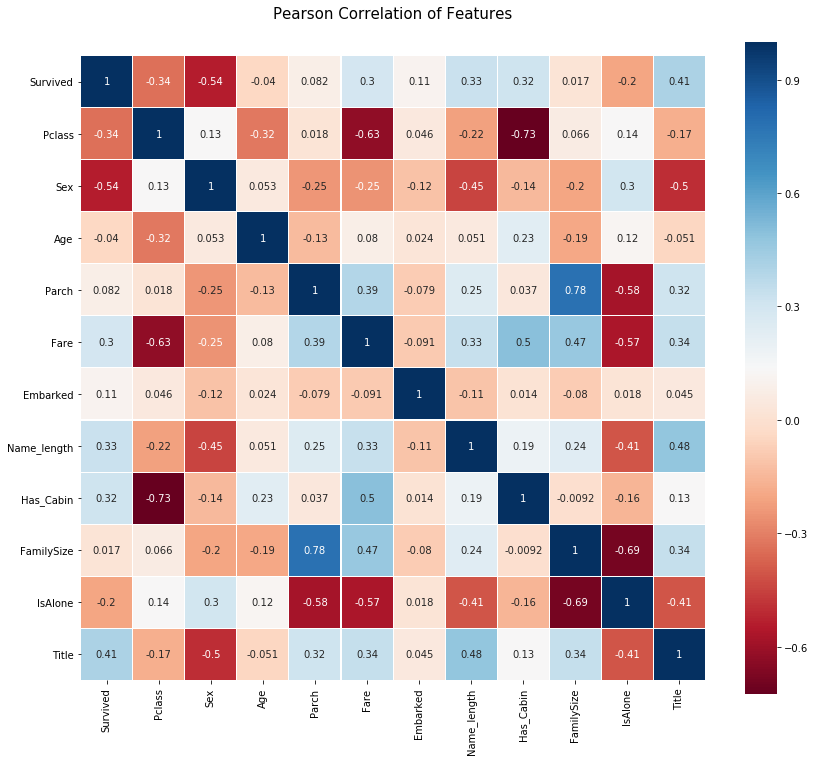

In [46]:
#visualize the correlation of features
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)

sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)


- Many features are highly correlated
- Most correlated: Parch - FamilySize

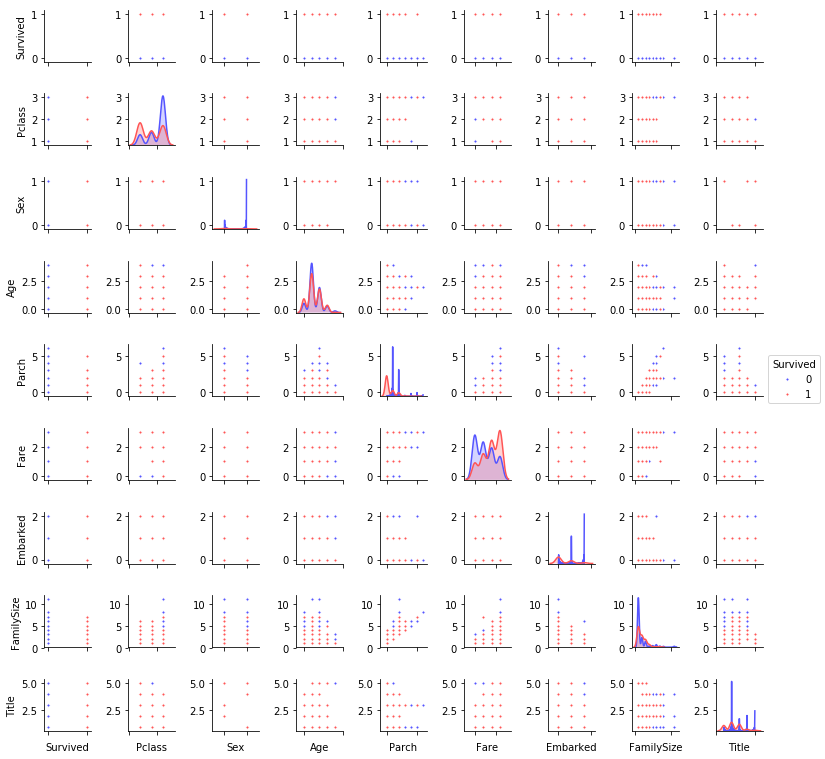

In [47]:
#visualize the correaltion of features by pairplots
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']], \
                      hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))

g.set(xticklabels=[])

## Ensembling & Stacking models

In [48]:
#useful parameters
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 #for reproducibility
NFOLDS = 5 #set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)

In [49]:
#build a helper for models
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)

### Out-of-Fold Predictions

In [50]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Build models

In [51]:
#build parameters for RandomForest model
rf_params={'n_jobs': -1, 
          'n_estimators': 500,
          'warm_start': True,
          'max_depth': 6,
          'min_samples_leaf': 2,
          'max_features': 'sqrt',
          'verbose': 0}

#build parameters for ExtraTree
et_params={'n_jobs': -1, 
          'n_estimators': 500,
          'max_depth': 8,
          'min_samples_leaf': 2,
          'verbose': 0}

#build parameters for AdaBoost
ada_params={'n_estimators': 500,
          'learning_rate': 0.75}

#build parameters for GradientBoosting
gb_params={'n_estimators': 500,
          'max_depth': 5,
          'min_samples_leaf': 2,
          'verbose': 0}

#build parameters for Support Vector Classifier model
svc_params={'kernel': 'linear',
            'C': 0.025}

In [52]:
#create five objects that represent four models
rf  = SklearnHelper(clf=RandomForestClassifier,     seed=SEED, params=rf_params)
et  = SklearnHelper(clf=ExtraTreesClassifier,       seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier,         seed=SEED, params=ada_params)
gb  = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC,                        seed=SEED, params=svc_params)

In [53]:
#create input numpy array of train, test and target
y_train = train['Survived'].ravel()
train=train.drop(['Survived'], axis=1)

x_train = train.values
x_test = test.values

### First level prediction output
- Use Out-of-Fold prediction function

In [54]:
#create Out-of-Fold(OOF) train and test predictions
et_oof_train,  et_oof_test  = get_oof(et,  x_train, y_train, x_test) # Extra Trees
rf_oof_train,  rf_oof_test  = get_oof(rf,  x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train,  gb_oof_test  = get_oof(gb,  x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [55]:
#feature importances
rf_features = rf.feature_importances(x_train,y_train) #[0.12828773  0.20121276  0.03326012  0.02112241  0.07168851  0.02347579 0.10842817  0.0640155   0.06588913  0.01387669  0.26874318]
et_features = et.feature_importances(x_train, y_train) #[0.12138723  0.3805171   0.02866059  0.01694122  0.05634396  0.02899479 0.04603567  0.08354407  0.04456296  0.02173265  0.17127976]
ada_features= ada.feature_importances(x_train, y_train) #[0.03   0.012  0.02   0.066  0.038  0.01   0.684  0.012  0.052  0.004 0.072]
gb_features = gb.feature_importances(x_train,y_train) #[0.06693326  0.03801013  0.10299663  0.03381598  0.10333392  0.06002392 0.38904547  0.01827095  0.07359865  0.02629424  0.08767685]

#assign them
rf_features =[0.12828773,  0.20121276,  0.03326012,  0.02112241,  0.07168851,  0.02347579, 0.10842817, 0.0640155,  0.06588913, 0.01387669,  0.26874318]
et_features =[0.12138723,  0.3805171,   0.02866059,  0.01694122,  0.05634396,  0.02899479, 0.04603567, 0.08354407, 0.04456296, 0.02173265,  0.17127976]
ada_features=[0.03,        0.012,       0.02,        0.066,       0.038,       0.01,       0.684,      0.012,      0.052,      0.004,       0.072]
gb_features =[0.06693326,  0.03801013,  0.10299663,  0.03381598,  0.10333392,  0.06002392, 0.38904547, 0.01827095, 0.07359865, 0.02629424,  0.08767685]

[ 0.12595221  0.19763416  0.02987502  0.02032452  0.07134002  0.02384112
  0.11001567  0.06435576  0.06873916  0.01336777  0.27455459]
[ 0.12002399  0.38018814  0.02597082  0.0164849   0.05528694  0.02834273
  0.04799032  0.08340751  0.04418531  0.02179606  0.17632328]
[ 0.03   0.01   0.016  0.066  0.036  0.01   0.692  0.014  0.05   0.006
  0.07 ]
[ 0.08300789  0.04636054  0.09744884  0.02487671  0.10685158  0.04914212
  0.38815828  0.02074043  0.0698743   0.02612153  0.08741778]


In [56]:
#create a dataframe with feature importance
cols = train.columns.values

feature_dataframe = pd.DataFrame({'features': cols,
                                  'Random Forest feature importances': rf_features,
                                  'Extra Trees  feature importances': et_features,
                                  'AdaBoost feature importances': ada_features,
                                  'Gradient Boost feature importances': gb_features})

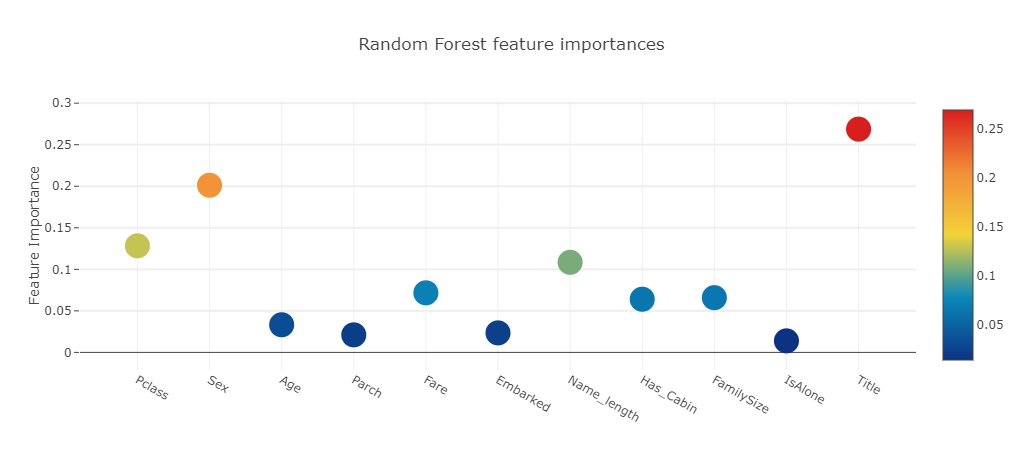

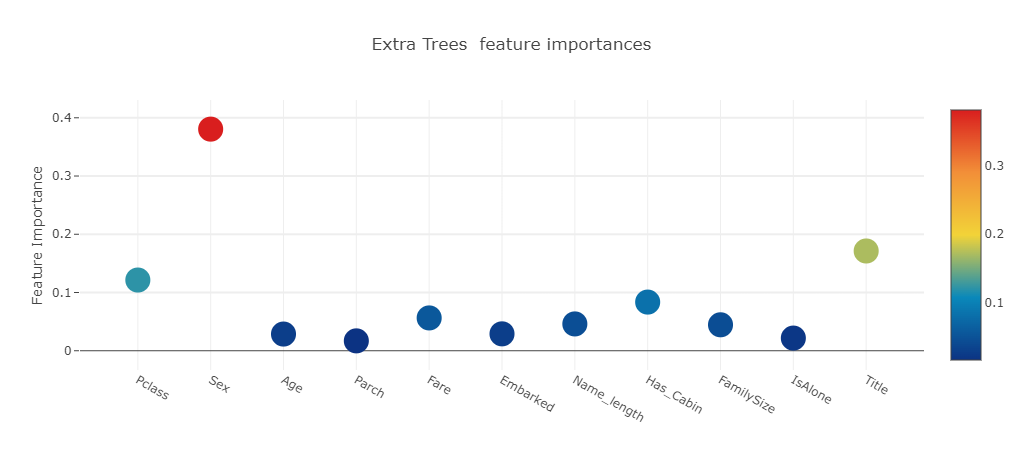

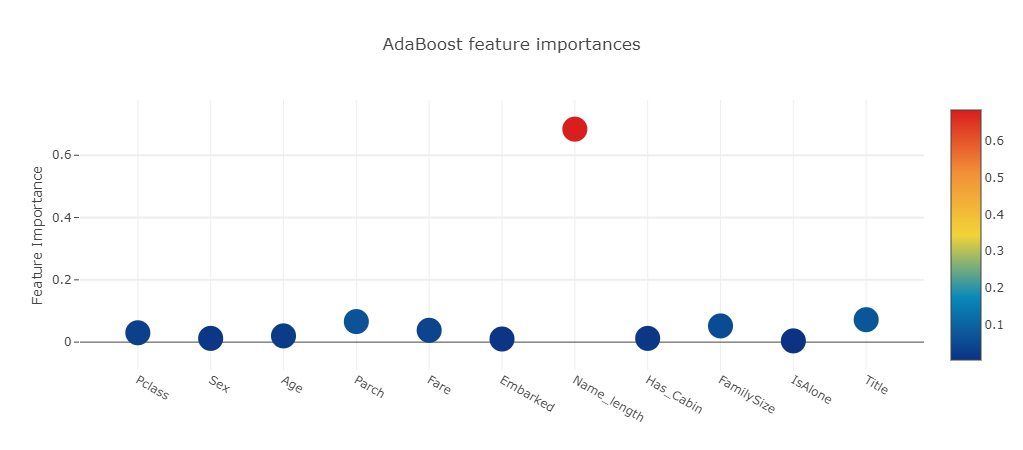

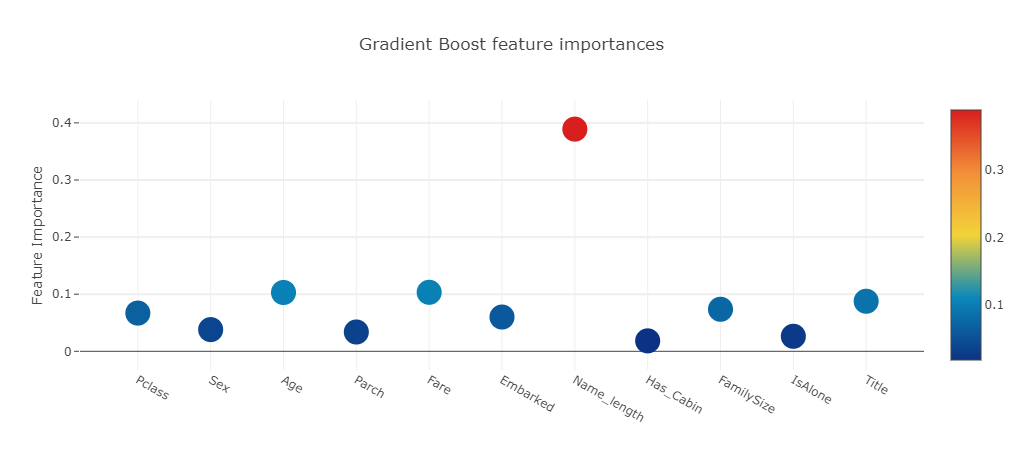

In [57]:
#visualize the feature importance
feature_importance=['Random Forest feature importances',
                    'Extra Trees  feature importances',
                    'AdaBoost feature importances',
                    'Gradient Boost feature importances']

for feature in feature_importance:
    trace = go.Scatter(y=feature_dataframe[feature].values,
                       x = feature_dataframe['features'].values,
                       mode='markers',
                       marker=dict(sizemode='diameter',
                                   sizeref = 1,
                                   size = 25,
                                   color=feature_dataframe[feature].values,
                                   colorscale='Portland',
                                   showscale=True),
                       text = feature_dataframe['features'].values)

    data = [trace]

    layout= go.Layout(autosize= True, title=feature, hovermode='closest',
                      yaxis=dict(title='Feature Importance', ticklen= 5, gridwidth= 2), showlegend= False)

    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig,filename='scatter2010')


In [58]:
#create new feature: mean of features' importances
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.128288,0.121387,0.030,0.066933,0.086652
1,Sex,0.201213,0.380517,0.012,0.038010,0.157935
2,Age,0.033260,0.028661,0.020,0.102997,0.046229


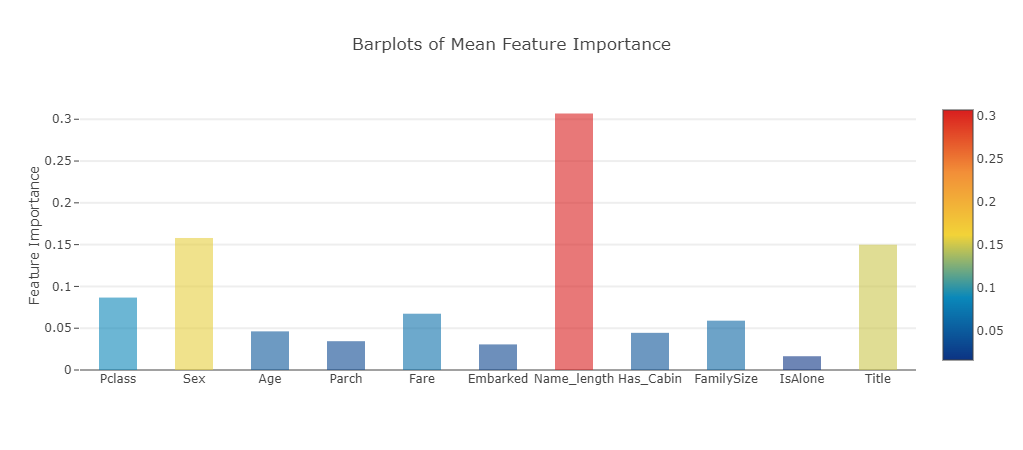

In [59]:
#visualize the mean feature
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(x= x,
               y= y,
               width = 0.5,
               marker=dict(color=feature_dataframe['mean'].values,
                           colorscale='Portland',
                           showscale=True,
                           reversescale = False),
               opacity=0.6)]

layout= go.Layout(autosize= True,
                  title= 'Barplots of Mean Feature Importance',
                  hovermode= 'closest',
                  yaxis=dict(title= 'Feature Importance',
                             ticklen= 5,
                             gridwidth= 2),
                  showlegend= False)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='bar-direct-labels')

### Second level prediction output
- Use first level output

In [60]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'AdaBoost': ada_oof_train.ravel(),
                                       'GradientBoost': gb_oof_train.ravel()})

base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


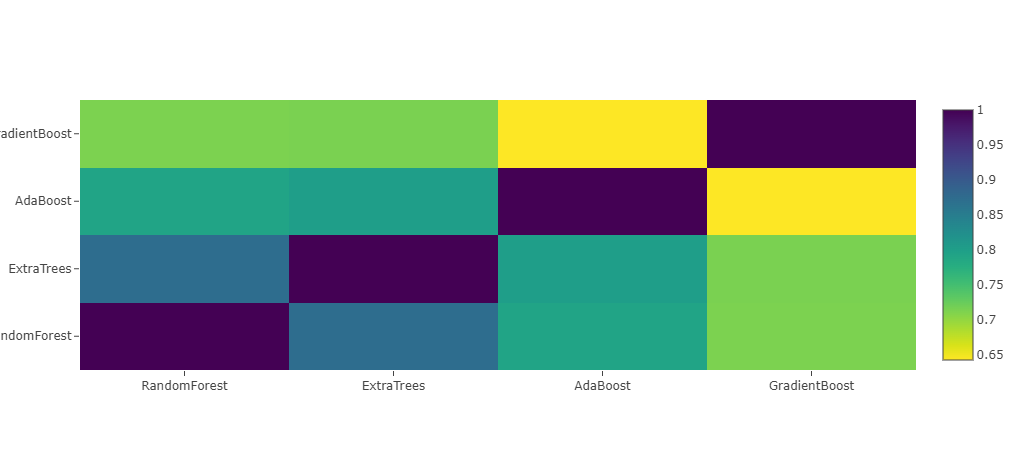

In [61]:
#visualize the correlation of second level training set
data = [go.Heatmap(z= base_predictions_train.astype(float).corr().values,
                   x=base_predictions_train.columns.values,
                   y= base_predictions_train.columns.values,
                   colorscale='Viridis',
                   showscale=True,
                   reversescale = True)]

py.iplot(data, filename='labelled-heatmap')

'There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.'

In [62]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test  = np.concatenate((et_oof_test,  rf_oof_test,  ada_oof_test,  gb_oof_test,  svc_oof_test),  axis=1)

In [63]:
#predict using XBClassifier and the first-level train data + target data
gbm = xgb.XGBClassifier(n_estimators= 2000,
                        max_depth= 4,
                        min_child_weight= 2,
                        gamma=0.9,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective= 'binary:logistic',
                        nthread= -1,
                        scale_pos_weight=1).fit(x_train, y_train)

predictions = gbm.predict(x_test)

In [67]:
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions })
StackingSubmission
#StackingSubmission.to_csv('StackingSubmission.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
